In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)
pd.options.display.float_format = '{:,.4f}'.format

# %matplotlib inline
plt.rcParams['figure.figsize'] = (12, 10)

# Makes graphs crisp. Only use if you don't have a lot of points/lines on your graph.
%config InlineBackend.figure_formats = ['svg', 'retina'] # use svg, then retina if svg is not supported

In [2]:
os.makedirs('csv', exist_ok=True)

In [3]:
input_params = {'Arbitrum': 'Glp Price Comparison_2021-08-31_2022-06-11.csv', 
                'Avalanche': 'Glp Price Comparison_2022-01-06_2022-06-11.csv'}

## returns if held until today

In [4]:
lst_of_dfs = []
for chain, fname in input_params.items():
    df = pd.read_csv(os.path.join(chain, fname), parse_dates=['Date'], index_col='Date')
    
    rets = list()
    for start_dt in df.index:
        # start_dt = '2022-01-01'
        # glpPlusFees is based on GLP share of fees received and excluding esGMX rewards
        subdf = (df.loc[start_dt:, ['glpPrice', 'glpPlusFees']]
                   .assign(ret = lambda x: (x.glpPlusFees - x.glpPrice[0]) / x.glpPrice[0])
                )
        rets.append(subdf.ret[-1])
        
    lst_of_dfs.append(pd.DataFrame({'ret_{}'.format(chain): rets}, index=df.index))

In [5]:
df_ret = pd.concat(lst_of_dfs, axis=1)    
df_ret.index.name = 'enter_date'
df_ret.to_csv(os.path.join('csv', "glp_returns_without_esGMX.csv"))

## calc avg daily returns and their sampling distribution of the sample mean

In [6]:
chain = 'Arbitrum'
fname = input_params[chain]
df = pd.read_csv(os.path.join(chain, fname), parse_dates=['Date'], index_col='Date')
subdf = df.loc[:, ['glpPrice', 'glpPlusFees']]    
subdf['daily_ret'] = (subdf.glpPlusFees - subdf.glpPrice.shift(1)) / subdf.glpPrice.shift(1)
subdf.head().style.format({'daily_ret': '{:.2%}'})

,glpPrice,glpPlusFees,daily_ret
Date,,,
2021-08-31 00:00:00,1.193543,1.193543,nan%
2021-09-01 00:00:00,1.293337,1.296321,8.61%
2021-09-02 00:00:00,1.288258,1.292273,-0.08%
2021-09-03 00:00:00,1.306217,1.311629,1.81%
2021-09-04 00:00:00,1.307664,1.313396,0.55%


In [7]:
sample_profile = dict()
dict_avg_rets = dict()
dict_avgs_n_ses = dict()
prob_avg_ret_gt0 = dict()
prob_avg_ret_gt10 = dict()

np.random.seed(42)
for chain, fname in input_params.items():
    
    # read data and calc daily returns
    subdf = pd.read_csv(os.path.join(chain, fname), parse_dates=['Date'], index_col='Date', 
                     usecols=['Date', 'glpPrice', 'glpPlusFees'])
    subdf['daily_ret'] = (subdf.glpPlusFees - subdf.glpPrice.shift(1)) / subdf.glpPrice.shift(1)
    daily_returns = subdf.daily_ret.dropna()
    
    # calc sample size, beginning and ending dates
    sample_profile[chain] = dict(size = len(daily_returns), 
                                 start_dt = daily_returns.index.min().date(), 
                                 end_dt = daily_returns.index.max().date())
    
    # calc sample avg and standard error
    avg_n_se = daily_returns.agg([np.mean, lambda x: np.std(x)/np.sqrt(len(x))])
    avg_n_se.index = ['avg', 'se']
    dict_avgs_n_ses[chain] = avg_n_se
    
    # generate the sampling distribution of the sample mean
    sampling_dist = np.random.normal(avg_n_se['avg'], avg_n_se['se'], size=50000000)
    dict_avg_rets[chain] = sampling_dist
    
    # calculate prob(avg > 0), prob(avg > 10%) 
    prob_avg_ret_gt0[chain] = np.sum(sampling_dist > 0) / len(sampling_dist)
    prob_avg_ret_gt10[chain] = np.sum(sampling_dist > 0.1) / len(sampling_dist)
    
df_avg_rets = pd.DataFrame(dict_avg_rets)
df_avgs_ses = pd.DataFrame(dict_avgs_n_ses)

In [8]:
df_avgs_ses

,Arbitrum,Avalanche
avg,0.1614,0.0999
se,0.0058,0.0040


In [9]:
sample_profile

{'Arbitrum': {'size': 284,
  'start_dt': datetime.date(2021, 9, 1),
  'end_dt': datetime.date(2022, 6, 11)},
 'Avalanche': {'size': 156,
  'start_dt': datetime.date(2022, 1, 7),
  'end_dt': datetime.date(2022, 6, 11)}}

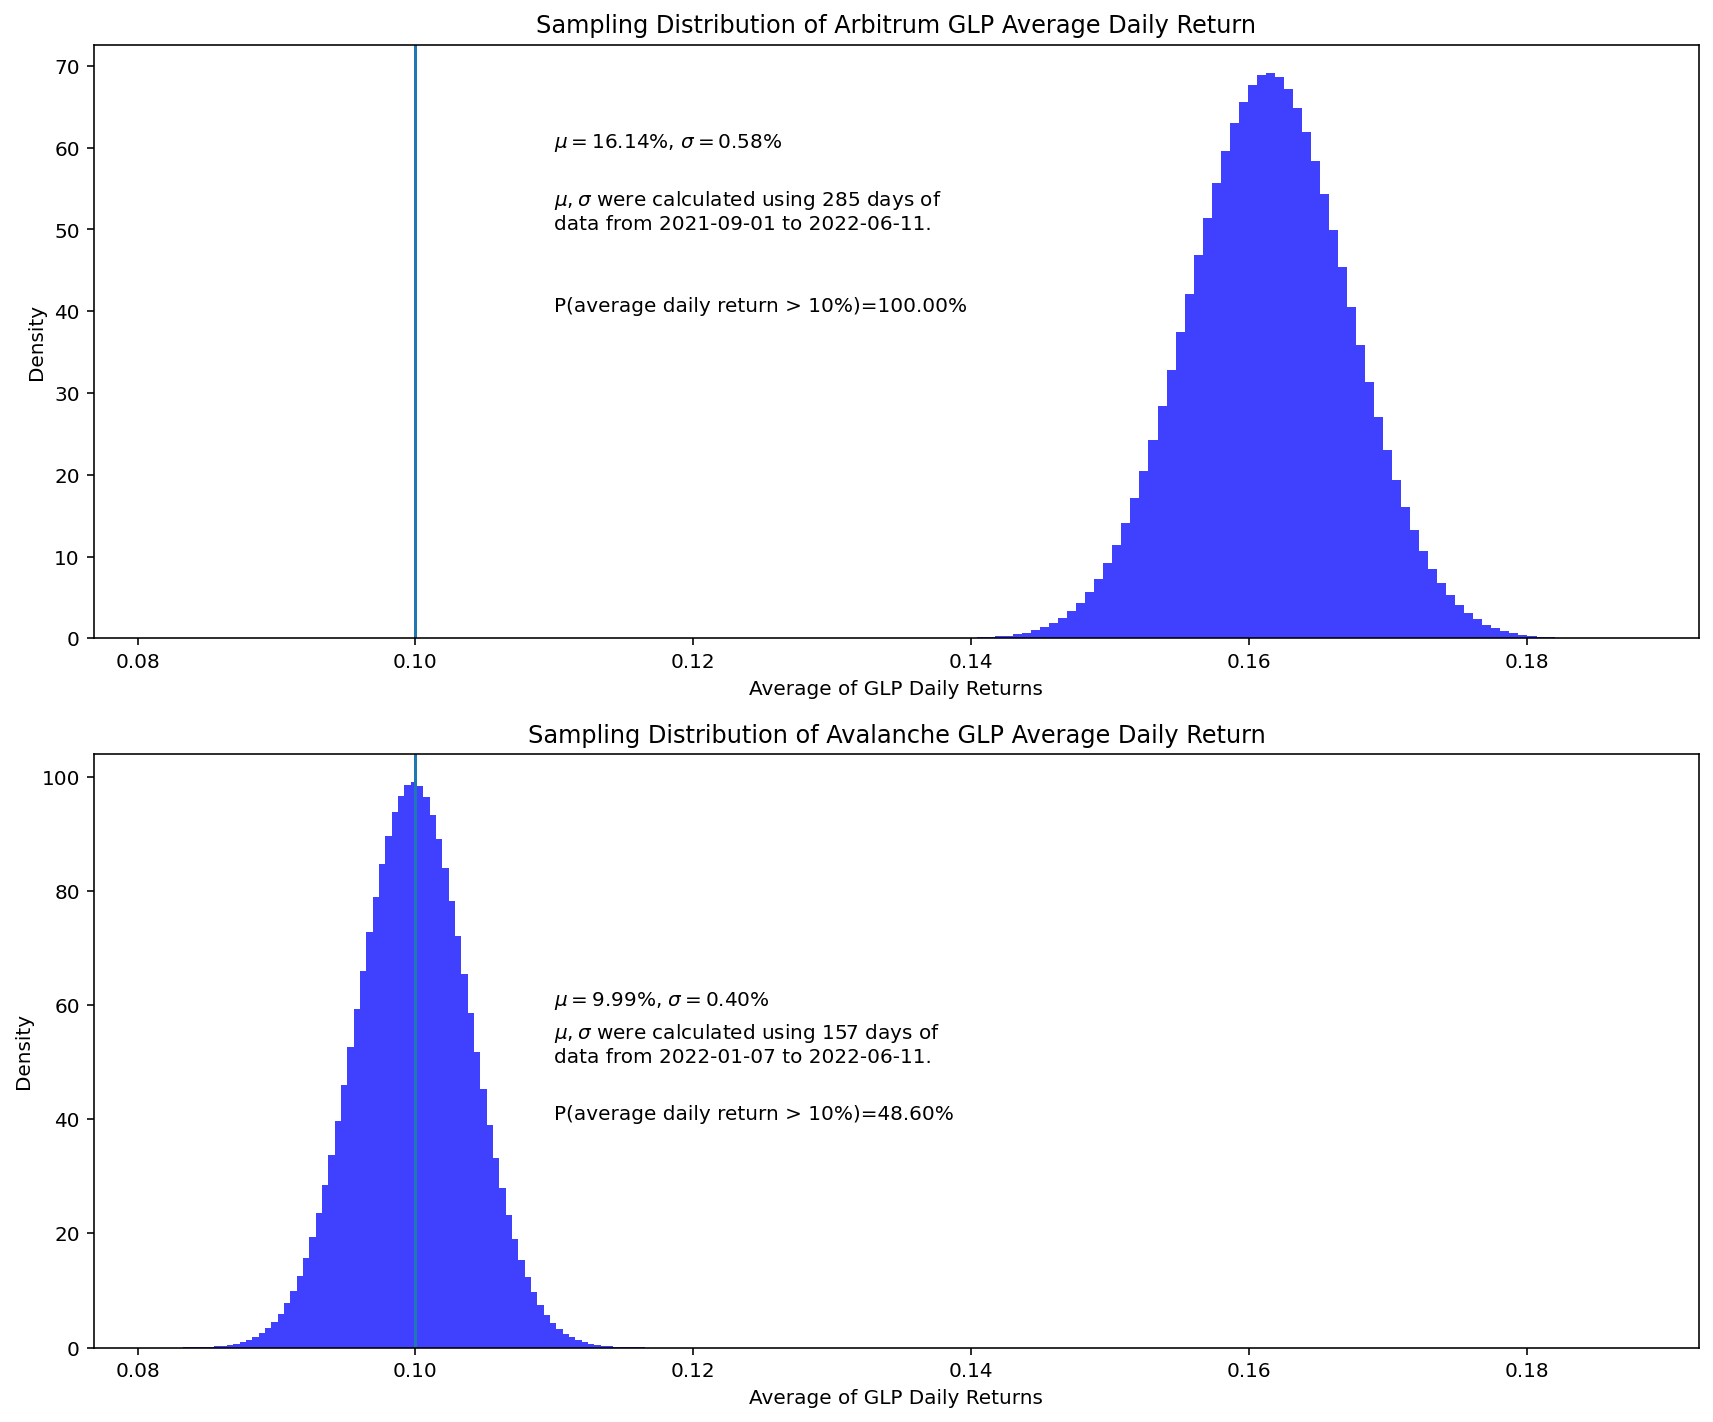

In [10]:
fig_path = os.path.join('png', "sampling_dist_of_glp_avg_daily_return.png")
fig = plt.figure()

# set the same xlim for both figures to compare their distributions
xlim_lwr = df_avg_rets.min().min()
xlim_upr = df_avg_rets.max().max()

for i, chain in enumerate(input_params.keys()):
    # add a subplot 
    ax = fig.add_subplot(2, 1, i+1)
    ax.hist(df_avg_rets[chain], 100, density=True, facecolor='b', alpha=0.75)
    ax.text(0.11, 60, r'$\mu=${:,.2%}, $\sigma=${:,.2%}'.format(df_avgs_ses.loc['avg', chain], df_avgs_ses.loc['se', chain]))
    ax.text(0.11, 50, 
            '$\mu, \sigma$ were calculated using {} days of\ndata from {} to {}.'\
         .format(sample_profile[chain]['size']+1, sample_profile[chain]['start_dt'], sample_profile[chain]['end_dt']))
    ax.text(0.11, 40, 
            "P(average daily return > 10%)={:.2%}".format(prob_avg_ret_gt10[chain]))    
    ax.axvline(x=0)
    ax.axvline(x=0.1)
    ax.set_xlim([xlim_lwr, xlim_upr])
    ax.set_title("Sampling Distribution of {} GLP Average Daily Return".format(chain))
    ax.set_xlabel("Average of GLP Daily Returns")
    ax.set_ylabel('Density')

fig.tight_layout()
fig.savefig(fig_path, dpi=100)        